# Library

At this stage, all the necessary Python libraries are imported for preprocessing.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.pipeline import Pipeline as ImbPipeline

from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv('../data/bank-full.csv', sep=';')

# Preprocessing

In the preprocessing stage, several key steps are performed to prepare the dataset for machine learning modeling.

In [3]:
df["y"] = df["y"].map({"yes": 1, "no": 0})

X_raw = df.drop("y", axis=1)
y = df["y"]

X_raw.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown


## Handling Missing Values for Numerical and Categorical Features

This code fills missing values based on feature type. Numerical columns are imputed using the median, while categorical columns use the most frequent value (mode).

In [4]:
for col in X_raw.columns:
    if X_raw[col].dtype in ["int64", "float64"]:
        X_raw[col] = X_raw[col].fillna(X_raw[col].median())
    else:
        mode_val = X_raw[col].mode()
        fill_val = mode_val[0] if not mode_val.empty else "unknown"
        X_raw[col] = X_raw[col].fillna(fill_val)

X_raw.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown


## Handling Special Value in pdays Feature

The value 999 in the pdays column indicates that the client was never previously contacted. This code replaces 999 with -1 to make the data more meaningful and easier for models to interpret.

In [5]:
if "pdays" in X_raw.columns:
    X_raw["pdays"] = X_raw["pdays"].replace(999, -1)

X_raw["pdays"].value_counts()

pdays
-1      36954
 182      167
 92       147
 183      126
 91       126
        ...  
 749        1
 769        1
 587        1
 778        1
 854        1
Name: count, Length: 559, dtype: int64

## Outlier Treatment Using the IQR Method

For each numerical feature, outliers are detected using the Interquartile Range (IQR). Values that fall below the lower bound or above the upper bound are capped to the nearest valid boundary. This process reduces extreme variations, stabilizes the feature distribution, and helps improve overall model performance.

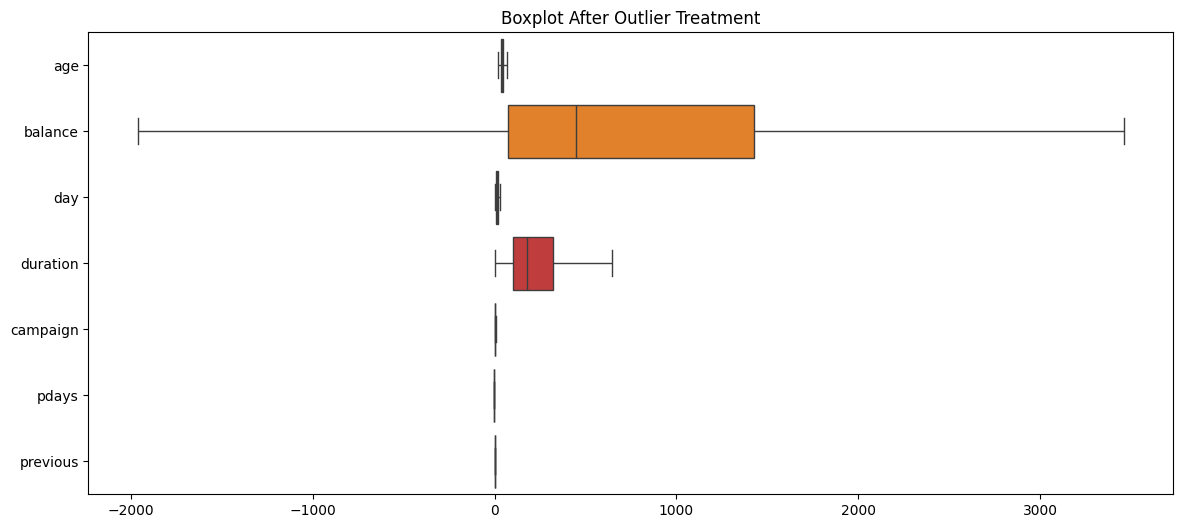

In [6]:
num_cols_raw = X_raw.select_dtypes(include=["int64", "float64"]).columns
for col in num_cols_raw:
    Q1 = X_raw[col].quantile(0.25)
    Q3 = X_raw[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    X_raw[col] = np.where(X_raw[col] < lower, lower,
                 np.where(X_raw[col] > upper, upper, X_raw[col]))

plt.figure(figsize=(14, 6))
sns.boxplot(data=X_raw[num_cols_raw], orient='h')
plt.title("Boxplot After Outlier Treatment")
plt.show()

## One-Hot Encoding for Categorical Features

Categorical features are transformed using One-Hot Encoding to convert each category into a binary vector. This ensures the model can interpret non-numeric values without introducing ordinal relationships. All encoded columns are combined with the numerical features to form the final processed dataset. The trained encoder is saved as a .pkl file so the same transformation can be applied during inference.

In [7]:
categorical_cols = X_raw.select_dtypes(include=["object"]).columns
numerical_cols = X_raw.select_dtypes(include=["int64", "float64"]).columns

ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
encoded_arr = ohe.fit_transform(X_raw[categorical_cols])
encoded_cols = ohe.get_feature_names_out(categorical_cols)

df_encoded = pd.DataFrame(encoded_arr, columns=encoded_cols, index=X_raw.index)

X_processed = pd.concat([X_raw[numerical_cols], df_encoded], axis=1)

joblib.dump(ohe, "../model/onehot_encoder.pkl")

X_processed.head()

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58.0,2143.0,5.0,261.0,1.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,44.0,29.0,5.0,151.0,1.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,33.0,2.0,5.0,76.0,1.0,-1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,47.0,1506.0,5.0,92.0,1.0,-1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,33.0,1.0,5.0,198.0,1.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Feature Scaling with StandardScaler

A subset of numerical features (age, balance, campaign, pdays, previous, day, duration) is scaled using standardization — subtracting the mean and dividing by the standard deviation. This ensures all features contribute fairly to model training regardless of their original value range. The fitted scaler is saved to scaler.pkl so that the same scaling can be applied during inference, ensuring consistency.

In [8]:
scaler = StandardScaler()
target_scale_cols = ["age", "balance", "campaign", "pdays", "previous", "day", "duration"]
cols_to_scale = [c for c in target_scale_cols if c in X_processed.columns]
X_processed[cols_to_scale] = scaler.fit_transform(X_processed[cols_to_scale])

joblib.dump(scaler, "../model/scaler.pkl")

X_processed.head()

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,1.648117,1.027653,-1.298476,0.147445,-0.870092,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.301287,-0.768817,-1.298476,-0.474910,-0.870092,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.756936,-0.791761,-1.298476,-0.899243,-0.870092,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.589894,0.486333,-1.298476,-0.808718,-0.870092,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.756936,-0.792611,-1.298476,-0.208994,-0.870092,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Displaying All Feature

This line of code is used to show all column names (features) contained in the dataframe X_processed after preprocessing steps have been applied.

In [9]:
print(X_processed.columns.tolist())

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'education_primary', 'education_secondary', 'education_tertiary', 'education_unknown', 'default_no', 'default_yes', 'housing_no', 'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular', 'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_other', 'poutcome_success', 'poutcome_unknown']


# Data Splitting

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, stratify=y, random_state=42
)

print(f"X_train: {X_train.shape}")
print(f"X_test : {X_test.shape}")

X_train: (36168, 51)
X_test : (9043, 51)


In [11]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("\nLabel sebelum SMOTE:")
print(y_train.value_counts())

print("\nLabel sesudah SMOTE:")
print(y_train_res.value_counts())


Label sebelum SMOTE:
y
0    31937
1     4231
Name: count, dtype: int64

Label sesudah SMOTE:
y
0    31937
1    31937
Name: count, dtype: int64


# Modelling

## Logistic Regression

In [12]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_res, y_train_res)

print("Logistic Regression training completed.")

Logistic Regression training completed.


## Random Forest

In [13]:
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_res, y_train_res)

print("Random Forest training completed.")

Random Forest training completed.


## MLP

In [14]:
model = Sequential([
    Input(shape=(X_train_res.shape[1],)),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

early = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train_res, y_train_res,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early],
    verbose=1
)

print("MLP training completed.")

Epoch 1/20
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8316 - loss: 0.3719 - val_accuracy: 0.8971 - val_loss: 0.4012
Epoch 2/20
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8633 - loss: 0.3184 - val_accuracy: 0.9011 - val_loss: 0.3552
Epoch 3/20
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8714 - loss: 0.3036 - val_accuracy: 0.9321 - val_loss: 0.2895
Epoch 4/20
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8759 - loss: 0.2941 - val_accuracy: 0.9218 - val_loss: 0.2969
Epoch 5/20
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8796 - loss: 0.2862 - val_accuracy: 0.9220 - val_loss: 0.2947
Epoch 6/20
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8811 - loss: 0.2818 - val_accuracy: 0.9199 - val_loss: 0.2990
Epoch 7/20
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8848 - loss: 0.2749 - val_accuracy: 0.9323 - val_loss: 0.2680
Epoch 8/20
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8863 - loss: 0.2707 - 

# Evaluasi

## Logistic Regression


Logistic Regression
Train Accuracy : 0.8464
Test Accuracy  : 0.8322

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.83      0.90      7985
           1       0.40      0.82      0.53      1058

    accuracy                           0.83      9043
   macro avg       0.68      0.83      0.72      9043
weighted avg       0.90      0.83      0.86      9043



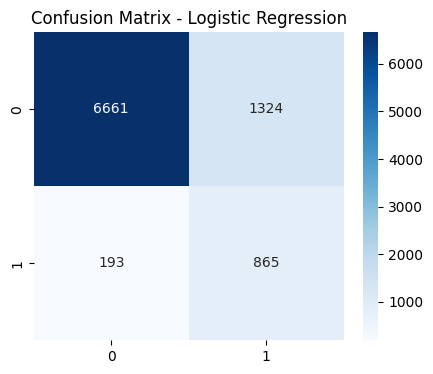

In [15]:
log_train_acc = log_model.score(X_train_res, y_train_res)
log_pred = log_model.predict(X_test)
log_test_acc = accuracy_score(y_test, log_pred)

print("\nLogistic Regression")
print(f"Train Accuracy : {log_train_acc:.4f}")
print(f"Test Accuracy  : {log_test_acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, log_pred))

plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, log_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

## Random Forest


Random Forest
Train Accuracy : 1.0000
Test Accuracy  : 0.8995

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      7985
           1       0.57      0.55      0.56      1058

    accuracy                           0.90      9043
   macro avg       0.76      0.75      0.75      9043
weighted avg       0.90      0.90      0.90      9043



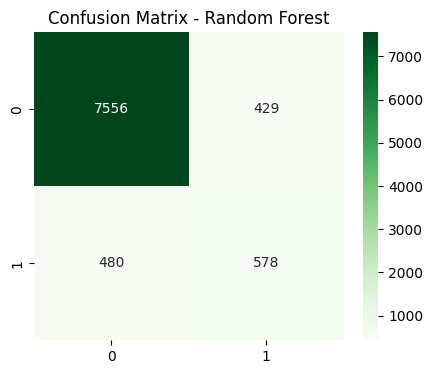

In [16]:
rf_train_acc = rf_model.score(X_train_res, y_train_res)
rf_pred = rf_model.predict(X_test)
rf_test_acc = accuracy_score(y_test, rf_pred)

print("\nRandom Forest")
print(f"Train Accuracy : {rf_train_acc:.4f}")
print(f"Test Accuracy  : {rf_test_acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, rf_pred))

plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, rf_pred), annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - Random Forest")
plt.show()

## MLP (Deep Learning)

283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step

Deep Learning (MLP)
Train Accuracy : 0.8985
Test Accuracy  : 0.8704

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.88      0.92      7985
           1       0.47      0.78      0.59      1058

    accuracy                           0.87      9043
   macro avg       0.72      0.83      0.75      9043
weighted avg       0.91      0.87      0.88      9043



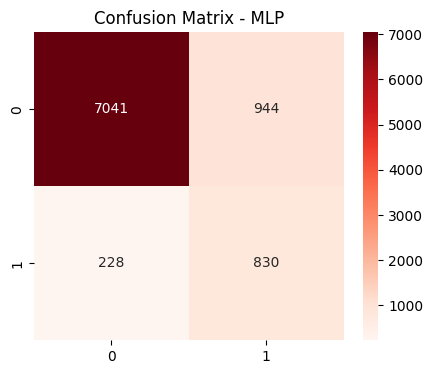

In [17]:
mlp_train_acc = history.history["accuracy"][-1]
y_pred_probs = model.predict(X_test)
y_pred_dl = (y_pred_probs > 0.5).astype("int32")
mlp_test_acc = accuracy_score(y_test, y_pred_dl)

print("\nDeep Learning (MLP)")
print(f"Train Accuracy : {mlp_train_acc:.4f}")
print(f"Test Accuracy  : {mlp_test_acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dl))

plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_dl), annot=True, fmt="d", cmap="Reds")
plt.title("Confusion Matrix - MLP")
plt.show()

## Model Terbaik

In [18]:
acc_log = accuracy_score(y_test, log_pred)
acc_rf = accuracy_score(y_test, rf_pred)
acc_dl = accuracy_score(y_test, y_pred_dl)

print("\nMODEL COMPARISON")
print("Logistic Regression Accuracy :", acc_log)
print("Random Forest Accuracy       :", acc_rf)
print("Deep Learning (MLP) Accuracy :", acc_dl)

best_model_name = max(
    [("logistic", acc_log), ("random_forest", acc_rf), ("deep_learning", acc_dl)],
    key=lambda x: x[1]
)[0]

print("\nBEST MODEL:", best_model_name.upper())


MODEL COMPARISON
Logistic Regression Accuracy : 0.8322459360831582
Random Forest Accuracy       : 0.8994802609753401
Deep Learning (MLP) Accuracy : 0.8703969921486232

BEST MODEL: RANDOM_FOREST


## Feature Importances (Based on Best Model)

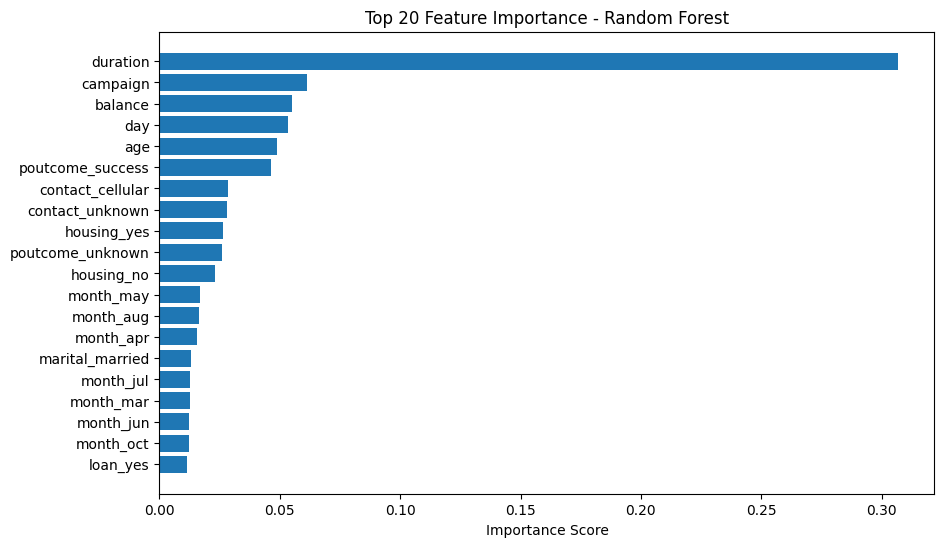

In [19]:
importances = rf_model.feature_importances_
feature_names = X_train_res.columns

rf_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False).head(20)

plt.figure(figsize=(10, 6))
plt.barh(rf_imp_df["Feature"], rf_imp_df["Importance"])
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.show()

## Cross Validation

In [20]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Logistic Regression
log_pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('logreg', LogisticRegression(max_iter=1000))
])

log_cv_scores = cross_val_score(log_pipeline, X_processed, y,
                                cv=kfold, scoring='accuracy')

print("\nCROSS VALIDATION: Logistic Regression")
print("Scores:", log_cv_scores)
print("Mean Accuracy:", np.mean(log_cv_scores))

# Random Forest
rf_pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=200, random_state=42))
])

rf_cv_scores = cross_val_score(rf_pipeline, X_processed, y,
                               cv=kfold, scoring='accuracy')

print("\nCROSS VALIDATION: Random Forest")
print("Scores:", rf_cv_scores)
print("Mean Accuracy:", np.mean(rf_cv_scores))

# Deep Learning (MLP)
def create_mlp():
    model = Sequential([
        Input(shape=(X_processed.shape[1],)),
        Dense(64, activation="relu"),
        Dropout(0.3),
        Dense(32, activation="relu"),
        Dropout(0.2),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

mlp_scores = []

for train_idx, val_idx in kfold.split(X_processed, y):
    X_train_fold, X_val_fold = X_processed.iloc[train_idx], X_processed.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train_fold, y_train_fold)

    mlp = create_mlp()
    mlp.fit(X_train_res, y_train_res, epochs=10, batch_size=32, verbose=0)

    _, acc = mlp.evaluate(X_val_fold, y_val_fold, verbose=0)
    mlp_scores.append(acc)

print("\nCROSS VALIDATION: Deep Learning (MLP)")
print("Scores:", mlp_scores)
print("Mean Accuracy:", np.mean(mlp_scores))



CROSS VALIDATION: Logistic Regression
Scores: [0.83644808 0.83488166 0.8295731  0.83764654 0.83156381]
Mean Accuracy: 0.8340226399451142

CROSS VALIDATION: Random Forest
Scores: [0.89881676 0.90002212 0.89460296 0.90212342 0.8915063 ]
Mean Accuracy: 0.8974143150461324

CROSS VALIDATION: Deep Learning (MLP)
Scores: [0.8640937805175781, 0.865074098110199, 0.8513603210449219, 0.8648529052734375, 0.8527980446815491]
Mean Accuracy: 0.8596358299255371


# Lead Scoring

In [21]:
probs = model.predict(X_test).flatten()
lead_score = (probs * 100).astype(int)

def categorize(score):
    if score >= 70: return "HIGH PRIORITY"
    if score >= 40: return "MEDIUM PRIORITY"
    return "LOW PRIORITY"

priority = [categorize(x) for x in lead_score]

final_sales_view = X_test.copy()
final_sales_view["Actual_Label"] = y_test
final_sales_view["Probability"] = probs
final_sales_view["Lead Score"] = lead_score
final_sales_view["Lead Priority"] = priority

final_sales_view = final_sales_view.sort_values("Lead Score", ascending=False)

print("\nTop 20 Hot Leads")
display(final_sales_view.head(20))

283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step

Top 20 Hot Leads


,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,Actual_Label,Probability,Lead Score,Lead Priority
42449,0.108883,-0.577613,-0.817845,0.300205,2.254727,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1,0.977069,97,HIGH PRIORITY
42730,2.850644,2.148534,1.224839,2.308715,-0.870092,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1,0.972295,97,HIGH PRIORITY
44128,-1.334149,-0.728027,-0.457371,0.396388,1.004799,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0,0.978865,97,HIGH PRIORITY
41532,-0.853138,-0.037992,-0.697687,-0.282545,-0.870092,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1,0.973416,97,HIGH PRIORITY
43294,-0.564532,-0.570814,-0.096898,1.086636,-0.870092,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1,0.969406,96,HIGH PRIORITY
44382,-0.372128,-0.740774,-1.658950,1.092294,-0.245128,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1,0.961614,96,HIGH PRIORITY
31281,0.301287,-0.383009,-1.178318,-0.158074,-0.245128,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1,0.966449,96,HIGH PRIORITY
43135,-1.526553,-0.394906,0.984523,1.635440,-0.870092,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0,0.962627,96,HIGH PRIORITY
43860,-1.334149,-0.246192,-1.658950,2.308715,-0.870092,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1,0.963064,96,HIGH PRIORITY
44725,0.974702,-0.665142,-0.938003,2.280426,-0.870092,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1,0.965733,96,HIGH PRIORITY


# Menyimpan Model

In [22]:
# Logistic Regression
joblib.dump(log_model, "../model/logreg_model_smote.pkl")

# Random Forest
joblib.dump(rf_model, "../model/random_forest_smote.pkl")

# Deep Learning
model.save("../model/lead_scoring_mlp.keras")

if best_model_name == "deep_learning":
    model.save("../model/BEST_MODEL.h5")
    print("Best Model saved as: BEST_MODEL.h5 (Deep Learning)")
else:
    if best_model_name == "logistic":
        joblib.dump(log_model, "../model/BEST_MODEL.pkl")
        print("Best Model saved as: BEST_MODEL.pkl (Logistic Regression)")
    elif best_model_name == "random_forest":
        joblib.dump(rf_model, "../model/BEST_MODEL.pkl")
        print("Best Model saved as: BEST_MODEL.pkl (Random Forest)")

print("\nAll models saved successfully based on best classification result!")

Best Model saved as: BEST_MODEL.pkl (Random Forest)

All models saved successfully based on best classification result!
